In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures, Normalizer
from sklearn.model_selection import train_test_split, RepeatedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, ElasticNetCV, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.gaussian_process import GaussianProcessRegressor
import catboost as cb
from xgboost import XGBRegressor
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

## Загружаем датасет для моделирования на цель "Модуль упругости на растяжение"

In [2]:
# Данные без BoxCox преобразования (производилось по ряду признаков)
data_elasticity = pd.read_csv('../../data/processing/elasticity_on_stretching.csv', sep=';', index_col=0)


# Данные с BoxCox преобразования (производилось по ряду признаков)
# data_elasticity = pd.read_csv('../../data/data_for_model/target_1_elasticity_on_stretching_data_ready_for_model.csv', sep=';', index_col=[0])


data_elasticity

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,elasticity_on_stretching,resin,cover_angle,cover_step,cover_strength
0,1.857143,2030.000000,738.736842,30.000000,22.267857,100.000000,210.000000,70.000000,220.000000,0,4.000000,57.000000
1,1.857143,2030.000000,738.736842,50.000000,23.750000,284.615385,210.000000,70.000000,220.000000,0,4.000000,60.000000
2,1.857143,2030.000000,738.736842,49.900000,33.000000,284.615385,210.000000,70.000000,220.000000,0,4.000000,70.000000
3,1.857143,2030.000000,738.736842,129.000000,21.250000,300.000000,210.000000,70.000000,220.000000,0,5.000000,47.000000
4,2.771331,2030.000000,753.000000,111.860000,22.267857,284.615385,210.000000,70.000000,220.000000,0,5.000000,57.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1018,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,125.007669,1,9.076380,47.019770
1019,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,117.730099,1,10.565614,53.750790
1020,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,236.606764,1,4.161154,67.629684
1021,3.705351,2066.799773,741.475517,141.397963,19.246945,275.779840,641.468152,74.042708,197.126067,1,6.313201,58.261074


In [3]:
# Убираем подозрительные данные, как бы занесённые в исходную таблицу вручную (есть такое предположение) 
data_elasticity = data_elasticity.loc[data_elasticity.index[22:], :].reset_index(drop=True)
data_elasticity

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,elasticity_on_stretching,resin,cover_angle,cover_step,cover_strength
0,4.029126,1880.000000,622.000000,111.860000,22.267857,284.615385,470.000000,73.333333,220.000000,1,4.000000,60.000000
1,2.587348,1953.274926,1136.596135,137.627420,22.344534,234.716883,555.893453,80.803222,246.613117,1,4.000000,70.000000
2,2.499918,1942.595777,901.519947,146.252208,23.081757,351.231874,864.725484,76.178075,226.222760,1,5.000000,47.000000
3,2.046471,2037.631811,707.570887,101.617251,23.146393,312.307205,547.601219,73.817067,178.198556,1,5.000000,57.000000
4,1.856476,2018.220332,836.294382,135.401697,26.435515,327.510377,150.961449,77.210762,123.344561,1,5.000000,60.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
996,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,125.007669,1,9.076380,47.019770
997,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,117.730099,1,10.565614,53.750790
998,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,236.606764,1,4.161154,67.629684
999,3.705351,2066.799773,741.475517,141.397963,19.246945,275.779840,641.468152,74.042708,197.126067,1,6.313201,58.261074


In [4]:
data_elasticity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   matrix_filler_ratio       1001 non-null   float64
 1   density                   1001 non-null   float64
 2   elasticity                1001 non-null   float64
 3   hardener                  1001 non-null   float64
 4   epoxid                    1001 non-null   float64
 5   temperature               1001 non-null   float64
 6   surface_density           1001 non-null   float64
 7   elasticity_on_stretching  1001 non-null   float64
 8   resin                     1001 non-null   float64
 9   cover_angle               1001 non-null   int64  
 10  cover_step                1001 non-null   float64
 11  cover_strength            1001 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 94.0 KB


In [5]:
# Функции по чистке датасета от выбросов через IQR
def compute_IQR_boundaries(data):
    IQR = data.quantile(0.75) - data.quantile(0.25)
    IQR_bound_lower = data.quantile(0.25) - 1.5 * IQR
    IQR_bound_upper = data.quantile(0.75) + 1.5 * IQR
    return (IQR_bound_lower, IQR_bound_upper)


def detect_outliers(data):
    IQR = data.quantile(0.75) - data.quantile(0.25)
    IQR_bound_lower = data.quantile(0.25) - 1.5 * IQR
    IQR_bound_upper = data.quantile(0.75) + 1.5 * IQR
    res = [x if (x >= IQR_bound_lower) & (x <= IQR_bound_upper) else np.nan for x in data]
    return res

In [6]:
# Очищаем от "как бы" выбросов. Но, возможно, потом этого делать не будем 
data_elasticity = pd.DataFrame(data_elasticity.apply(detect_outliers, axis=0)).dropna().reset_index(drop=True)
data_elasticity

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,elasticity_on_stretching,resin,cover_angle,cover_step,cover_strength
0,4.029126,1880.000000,622.000000,111.860000,22.267857,284.615385,470.000000,73.333333,220.000000,1,4.000000,60.000000
1,2.587348,1953.274926,1136.596135,137.627420,22.344534,234.716883,555.893453,80.803222,246.613117,1,4.000000,70.000000
2,2.499918,1942.595777,901.519947,146.252208,23.081757,351.231874,864.725484,76.178075,226.222760,1,5.000000,47.000000
3,2.046471,2037.631811,707.570887,101.617251,23.146393,312.307205,547.601219,73.817067,178.198556,1,5.000000,57.000000
4,1.856476,2018.220332,836.294382,135.401697,26.435515,327.510377,150.961449,77.210762,123.344561,1,5.000000,60.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
925,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,125.007669,1,9.076380,47.019770
926,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,117.730099,1,10.565614,53.750790
927,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,236.606764,1,4.161154,67.629684
928,3.705351,2066.799773,741.475517,141.397963,19.246945,275.779840,641.468152,74.042708,197.126067,1,6.313201,58.261074


In [7]:
# Принудительно перемешиваем датасет случайным образом, чтобы далее не думать над настройками параметра suffle у ряда методов.
data_elasticity = data_elasticity.sample(frac=1, random_state=42).reset_index(drop=True)
data_elasticity

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,elasticity_on_stretching,resin,cover_angle,cover_step,cover_strength
0,2.322801,1959.085228,427.989066,151.474357,21.105017,331.720071,33.684180,72.046952,324.956431,1,8.584800,43.918629
1,4.132379,2006.339130,1192.311117,85.631079,23.636298,289.566252,1010.765564,74.737493,208.279613,1,8.285425,60.029817
2,3.631935,2065.517880,553.620936,120.695878,24.431894,308.978565,234.161674,69.802191,266.138301,0,10.050718,74.156666
3,3.174404,1980.823788,459.047070,81.162535,21.787358,322.371649,233.898871,73.789821,200.414215,0,3.717884,48.955385
4,4.922781,2071.260438,408.294676,100.333696,20.478443,318.392904,691.280873,71.729136,159.365452,0,8.924450,72.954294
...,...,...,...,...,...,...,...,...,...,...,...,...
925,3.324535,1884.474321,517.796839,106.074955,20.409882,297.453359,730.289571,74.692191,247.845360,0,6.846999,39.270565
926,3.572790,1992.344782,724.109184,129.947268,22.013615,304.940980,914.470728,74.611652,164.448443,0,8.560055,58.271705
927,3.399960,1945.987320,650.249397,108.599976,17.046896,232.605853,66.298832,71.597343,151.185023,1,5.263851,70.828475
928,2.185093,2048.400772,564.665126,158.535067,24.882756,302.409267,449.089802,72.895374,194.521978,0,8.648431,41.091749


## Разбиваем исходный датасет на train и test выборки

In [8]:
y = data_elasticity[['elasticity_on_stretching']]
X = data_elasticity.drop(columns=['elasticity_on_stretching'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [9]:
X_train.describe()

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,resin,cover_angle,cover_step,cover_strength
count,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000
mean,2.901193,1973.048984,737.054395,109.986746,22.351408,286.936587,494.771463,218.203775,0.533026,6.837069,57.362859
std,0.895016,70.024422,326.458346,27.724555,2.377472,39.196167,278.670269,57.407335,0.499292,2.534974,11.235158
min,0.547391,1784.482245,9.986210,35.599697,16.391595,187.562353,0.603740,64.524180,0.000000,0.037639,28.237746
25%,2.277239,1926.001610,508.506970,91.331874,20.665390,259.066528,280.182711,182.027715,0.000000,5.074320,50.159197
50%,2.871562,1977.562320,728.965720,109.246571,22.394169,286.485705,469.978983,216.744240,1.000000,6.864121,57.627906
75%,3.511178,2019.640203,957.386959,130.563011,24.072879,314.772215,702.499250,256.925398,1.000000,8.556590,64.885883
max,5.258895,2158.794836,1649.415706,181.828448,28.955094,386.067992,1291.340115,359.052220,1.000000,13.653987,85.987174


In [10]:
X_test.describe()

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,resin,cover_angle,cover_step,cover_strength
count,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000
mean,2.995336,1976.785846,741.544218,111.639422,21.923182,282.773787,453.331975,215.553001,0.480287,7.032381,57.374774
std,0.887458,72.507259,332.190955,26.372195,2.486485,41.155910,279.522675,59.236339,0.500509,2.511652,11.425841
min,0.596783,1786.035636,2.436909,41.429139,15.695894,179.374391,1.668002,63.685698,0.000000,0.730260,27.272928
25%,2.434839,1919.862559,481.166159,94.355401,20.182640,257.172594,238.716648,170.786203,0.000000,5.201314,50.130739
50%,3.011978,1977.302956,750.903828,112.122685,21.845865,279.795870,422.627857,216.639017,0.000000,7.000059,57.000000
75%,3.598453,2022.407487,977.016627,129.424657,23.914575,309.780308,645.599863,255.359456,1.000000,8.679034,64.509983
max,5.314144,2161.565216,1588.677217,179.645962,27.920843,385.894771,1238.476416,356.925975,1.000000,13.732404,86.012427


In [ ]:
# Проверка двух выборок по тесту Колмогоров-Смирнов на их принадлежность к одной и той же "популяции" данных

# def my_test(dataframe, col_name, n_iter=10):
#     test_res = []
#     for i in np.arange(n_iter):
#         sample_1 = dataframe.loc[:, col_name].sample(310)
#         sample_2 = dataframe.loc[:, col_name].sample(310)
#         test_res.append(stats.ks_2samp(sample_1, sample_2, alternative='two-sided', method='auto')[1])
#     return np.mean(test_res)

# for col_name in data_elasticity.columns:
#     print(f'pval for {col_name}: {my_test(data_elasticity, "epoxid", 100)}')

## Временно "откладываем в сторону" категориальный признак (0 и 1) - Угол нашивки ('cover_angle')

In [11]:
cover_angle_train = pd.DataFrame(X_train.pop('cover_angle'))
cover_angle_test = pd.DataFrame(X_test.pop('cover_angle'))

# Проводим должные трансформации X-ов и создаём новые "синтетические" признаки
### Обусловлено выявленным отсутствием корреляции между признаками и целевой переменной.

### Перемножение признаков - кросс-эффекты. Осознанно это делаем до нормализации/стандартизации, чтобы не потерять масштаб взаимосвязей. Вопрос неоднозначный - перемножать до или после: мнения расходятся.

In [12]:
col_names = X_train.columns.tolist()
col_pair_combinations = list(itertools.combinations(col_names, 2))

X_train_cross = []

for col_pair in col_pair_combinations:
    X_train_cross.append(X_train.loc[:, col_pair].apply(lambda x: x[0] * x[1], axis=1))
    
X_train_cross = pd.DataFrame(X_train_cross).T
X_train_cross.columns = [f'{col_name[0]}_cross_{col_name[1]}' for col_name in col_pair_combinations]

### Возведение признаков в степень.

In [ ]:
# X_train_degree = X_train ** 2
# X_train_degree.columns = [f'{col_name}_degree' for col_name in X_train_degree.columns.tolist()]

### Промежуточная сборка Х-ов - признаков (исходных и новых)

In [13]:
# X_train = pd.concat([X_train, X_train_cross, X_train_degree], axis=1)
X_train = pd.concat([X_train, X_train_cross], axis=1)

# Стандартизация/нормализация X_train

In [14]:
# scaler = MinMaxScaler().fit(X_train)
# X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns.tolist())


# Прямой корреляционной связи признаков с целевой не наблюдается (по результатам EDA). Отсюда, есть предположение, что нормализовывать данные нужно не по ипризнакам (feature-wise), 
# а по наблюдениям (sample-wise), что как бы логично, т.к. речь идёт о разной рецептуре композитного материала.
# ... Но при таком подходе получается большая разница в размерности признаком (хотя, для, например, RandomForest - по нему комментарии нижк - это не проблема)

normalizer = Normalizer().fit(X_train)
X_train_norm = pd.DataFrame(normalizer.transform(X_train), index=X_train.index, columns=X_train.columns.tolist())

### Добавляем ещё новые признаки, которые создаём через PCA - главные компоненты

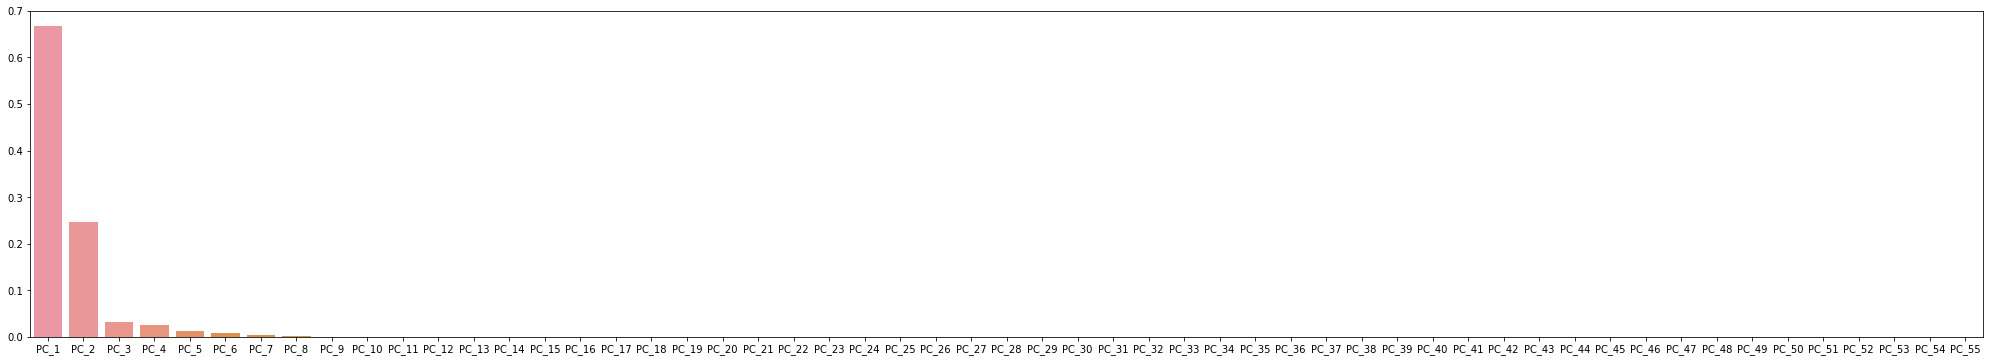

In [16]:
# pca = PCA().fit(X_train_scaled)
# X_train_pca = pd.DataFrame(pca.transform(X_train_scaled), columns=[f'PC_{i + 1}' for i in np.arange(X_train_scaled.shape[1])])

pca = PCA().fit(X_train_norm)
X_train_pca = pd.DataFrame(pca.transform(X_train_norm), columns=[f'PC_{i + 1}' for i in np.arange(X_train_norm.shape[1])])

plt.figure(figsize=(35, 6))
sns.barplot(x=X_train_pca.columns, y=pca.explained_variance_ratio_);

In [18]:
# X_train_pca = X_train_pca.loc[:, X_train_pca.columns[:10]]
# X_train_pca.index = X_train_scaled.index


# Выбираем первые две компоненты
X_train_pca = X_train_pca.loc[:, X_train_pca.columns[:2]]
X_train_pca.index = X_train_norm.index

# X_train to use

In [19]:
# Собираем все train Х-ы вместе
X_train_to_use = pd.concat([X_train_norm, cover_angle_train, X_train_pca], axis=1)
X_train_to_use

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,resin,cover_step,cover_strength,...,temperature_cross_cover_strength,surface_density_cross_resin,surface_density_cross_cover_step,surface_density_cross_cover_strength,resin_cross_cover_step,resin_cross_cover_strength,cover_step_cross_cover_strength,cover_angle,PC_1,PC_2
606,1.190089e-06,0.000905,0.000252,0.000033,0.000008,0.000119,0.000373,0.000089,0.000003,0.000024,...,0.006537,0.074350,0.002705,0.020407,0.000646,0.004872,0.000177,1,0.332403,-0.122961
593,1.817909e-06,0.001134,0.000433,0.000080,0.000013,0.000170,0.000053,0.000125,0.000002,0.000028,...,0.008276,0.011577,0.000184,0.002574,0.000435,0.006076,0.000097,1,-0.403310,0.146902
485,2.274900e-06,0.001607,0.000269,0.000100,0.000016,0.000273,0.000238,0.000082,0.000003,0.000055,...,0.019325,0.025229,0.001074,0.016876,0.000369,0.005793,0.000247,1,0.112951,0.211536
494,2.388871e-06,0.001115,0.000369,0.000066,0.000013,0.000169,0.000279,0.000130,0.000002,0.000036,...,0.010125,0.061306,0.001115,0.016720,0.000522,0.007826,0.000142,1,0.038495,-0.013184
752,1.611600e-06,0.000741,0.000374,0.000027,0.000009,0.000091,0.000316,0.000122,0.000002,0.000028,...,0.006193,0.094715,0.001420,0.021378,0.000549,0.008256,0.000124,1,0.084568,-0.183183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,8.070269e-07,0.000639,0.000408,0.000039,0.000010,0.000106,0.000227,0.000086,0.000003,0.000019,...,0.005941,0.058968,0.002285,0.012720,0.000870,0.004842,0.000188,1,-0.091067,-0.170839
270,3.601963e-06,0.002483,0.000188,0.000120,0.000034,0.000315,0.000237,0.000199,0.000009,0.000076,...,0.018977,0.037589,0.001685,0.014262,0.001416,0.011991,0.000537,0,0.223743,0.460316
860,1.674018e-06,0.000779,0.000498,0.000038,0.000010,0.000139,0.000011,0.000069,0.000004,0.000015,...,0.005067,0.001909,0.000109,0.000419,0.000661,0.002535,0.000145,0,-0.523604,0.043892
435,9.078971e-07,0.000906,0.000283,0.000060,0.000009,0.000136,0.000327,0.000110,0.000003,0.000024,...,0.007438,0.081027,0.002477,0.017886,0.000836,0.006036,0.000185,0,0.224562,-0.067264


# Применяем все те же трансформации к X_test

In [20]:
# Перемножаем признаки (cross-effects)

col_names = X_test.columns.tolist()
col_pair_combinations = list(itertools.combinations(col_names, 2))

X_test_cross = []

for col_pair in col_pair_combinations:
    X_test_cross.append(X_test.loc[:, col_pair].apply(lambda x: x[0] * x[1], axis=1))
    
X_test_cross = pd.DataFrame(X_test_cross).T
X_test_cross.columns = [f'{col_name[0]}_cross_{col_name[1]}' for col_name in col_pair_combinations]

In [21]:
# Возводим в степень

# X_test_degree = X_test ** 2
# X_test_degree.columns = [f'{col_name}_degree' for col_name in X_test_degree.columns.tolist()]

In [22]:
# Промежуточная сборка перед стандартизацией/нормированием

# X_test = pd.concat([X_test, X_test_cross, X_test_degree], axis=1)
X_test = pd.concat([X_test, X_test_cross], axis=1)

In [23]:
# Стандартизация/нормирование

# X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
X_test_norm = pd.DataFrame(normalizer.transform(X_test), index=X_test.index, columns=X_test.columns)

In [24]:
# Добавляем главные компоненты в качестве новых признаков

# X_test_pca = pd.DataFrame(pca.transform(X_test_scaled), columns=[f'PC_{i + 1}' for i in np.arange(X_test.shape[1])])
X_test_pca = pd.DataFrame(pca.transform(X_test_norm), columns=[f'PC_{i + 1}' for i in np.arange(X_test.shape[1])])
X_test_pca = X_test_pca.loc[:, X_test_pca.columns[:2]]
X_test_pca.index = X_test.index

# X_test to use

In [25]:
# X_test_to_use = pd.concat([X_test_scaled, cover_angle_test, X_test_pca], axis=1)
X_test_to_use = pd.concat([X_test_norm, cover_angle_test, X_test_pca], axis=1)

X_test_to_use

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,resin,cover_step,cover_strength,...,temperature_cross_cover_strength,surface_density_cross_resin,surface_density_cross_cover_step,surface_density_cross_cover_strength,resin_cross_cover_step,resin_cross_cover_strength,cover_step_cross_cover_strength,cover_angle,PC_1,PC_2
756,2.114272e-06,0.000874,0.000392,0.000056,0.000011,0.000122,0.000266,0.000078,0.000002,0.000030,...,0.008082,0.045588,0.001330,0.017672,0.000389,0.005174,0.000151,1,-0.013171,-0.146529
669,9.533422e-07,0.000610,0.000344,0.000032,0.000007,0.000089,0.000254,0.000052,0.000002,0.000022,...,0.006832,0.045797,0.001621,0.019454,0.000331,0.003971,0.000141,0,0.023491,-0.229708
30,3.061266e-06,0.002290,0.000329,0.000141,0.000023,0.000259,0.000138,0.000185,0.000007,0.000072,...,0.015901,0.021924,0.000879,0.008460,0.001183,0.011385,0.000457,0,-0.115216,0.351708
388,1.236720e-06,0.000888,0.000438,0.000046,0.000008,0.000128,0.000165,0.000110,0.000004,0.000019,...,0.005222,0.039535,0.001391,0.006725,0.000924,0.004467,0.000157,0,-0.227714,-0.055851
192,2.221525e-06,0.001225,0.000060,0.000049,0.000015,0.000213,0.000405,0.000155,0.000006,0.000040,...,0.013723,0.102626,0.003821,0.026147,0.001465,0.010027,0.000373,1,0.640282,0.249838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,1.400966e-06,0.001310,0.000405,0.000080,0.000016,0.000176,0.000133,0.000129,0.000002,0.000044,...,0.011830,0.026363,0.000434,0.008893,0.000422,0.008663,0.000142,1,-0.241793,0.107514
442,1.714044e-06,0.000856,0.000324,0.000043,0.000011,0.000094,0.000301,0.000116,0.000005,0.000025,...,0.005537,0.083241,0.003437,0.017690,0.001326,0.006826,0.000282,1,0.125150,-0.136970
409,2.334119e-06,0.001263,0.000390,0.000059,0.000016,0.000197,0.000229,0.000155,0.000003,0.000034,...,0.009927,0.052449,0.001165,0.011549,0.000787,0.007800,0.000173,0,-0.057360,0.070139
408,1.491433e-06,0.001052,0.000431,0.000024,0.000014,0.000149,0.000227,0.000035,0.000004,0.000039,...,0.010410,0.014441,0.001818,0.015881,0.000283,0.002469,0.000311,1,-0.120844,-0.140863


In [30]:
# Распределение целевой переменной test vs. train сильно отличается по количеству значений в диапазоне 72-75, что смущает / настораживает.

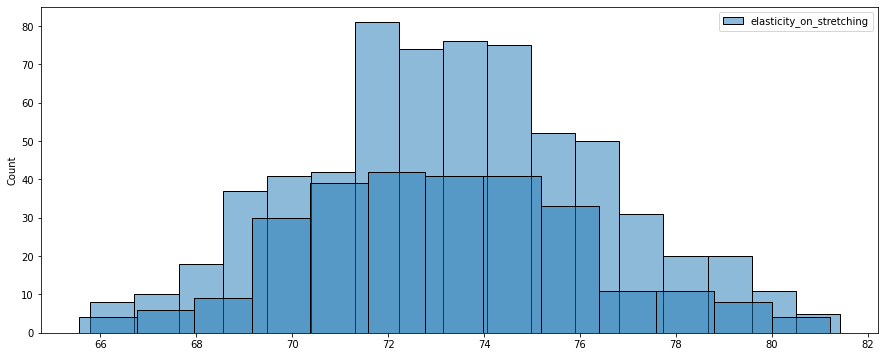

In [26]:
plt.figure(figsize=(15, 6))
sns.histplot(y_train)
sns.histplot(y_test);

In [27]:
y_train.var(), y_test.var(),

(elasticity_on_stretching    9.380199
 dtype: float64,
 elasticity_on_stretching    8.780383
 dtype: float64)

In [28]:
y_train.mean(), y_test.mean(),

(elasticity_on_stretching    73.373699
 dtype: float64,
 elasticity_on_stretching    73.150549
 dtype: float64)

In [29]:
y_train.median(), y_test.median(),

(elasticity_on_stretching    73.428673
 dtype: float64,
 elasticity_on_stretching    72.904773
 dtype: float64)

In [ ]:
# for col_name in X_train_to_use.columns.tolist():
#     fig, ax = plt.subplots(1, 1, figsize=(15, 6))
#     sns.histplot(X_train_to_use[col_name])
#     sns.histplot(X_test_to_use[col_name])
#     plt.show()

# На всякий случай сверяем картину test vs. train по корреляции с целевой переменной.

### Расположение признаков по показателю и знаку корреляции по test vs. train разное, и это опять же настораживаем. Можно было бы предположить, что это из-за 30% доли test выборки, но аналогичная нестабильная/неоднородная картина и при делении 50%-на-50%.  

In [33]:
data_train_temp = pd.concat([y_train, X_train_to_use], axis=1)
data_test_temp = pd.concat([y_test, X_test_to_use], axis=1)

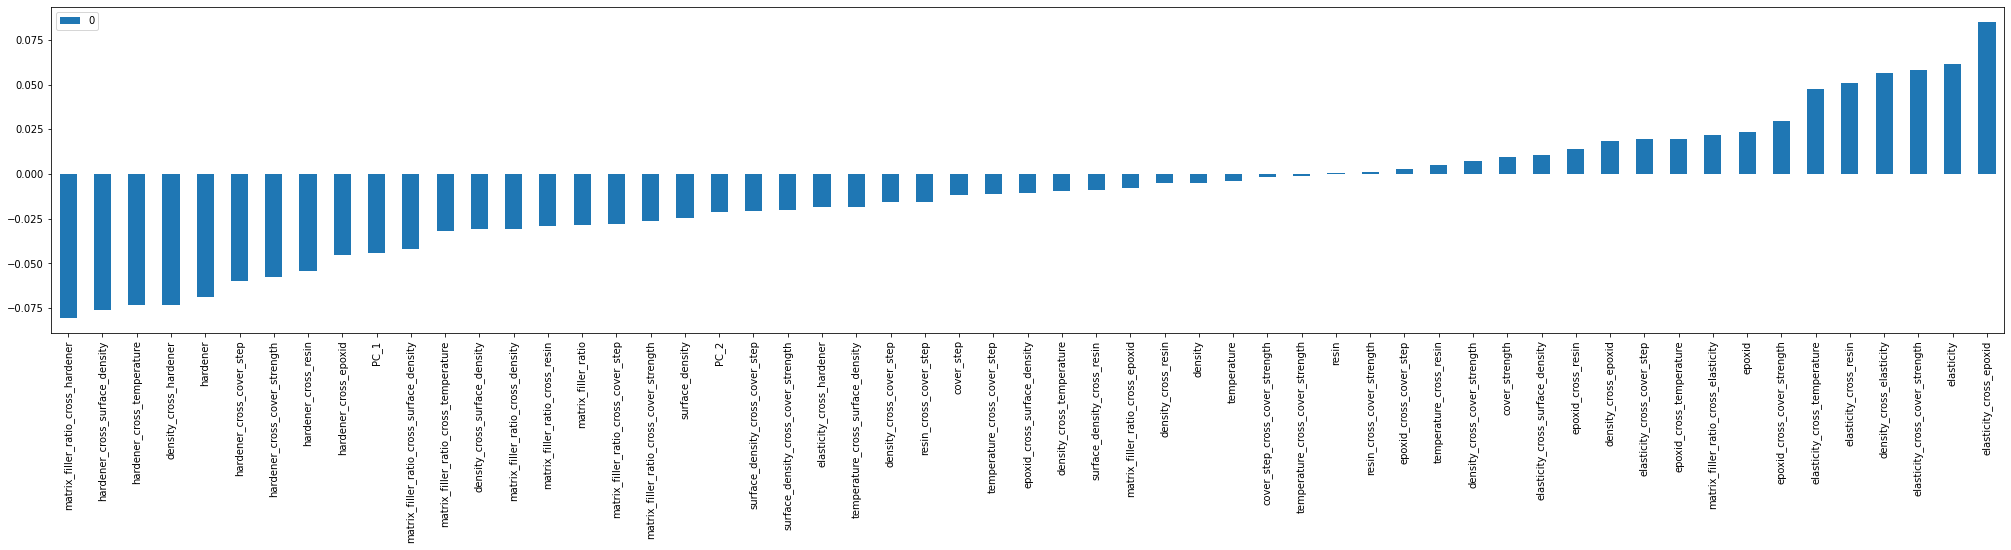

In [35]:
pd.DataFrame(data_train_temp.drop(columns=['cover_angle']).corrwith(data_train_temp['elasticity_on_stretching']).sort_values()[:-1]).plot(kind='bar', figsize=(35, 6));

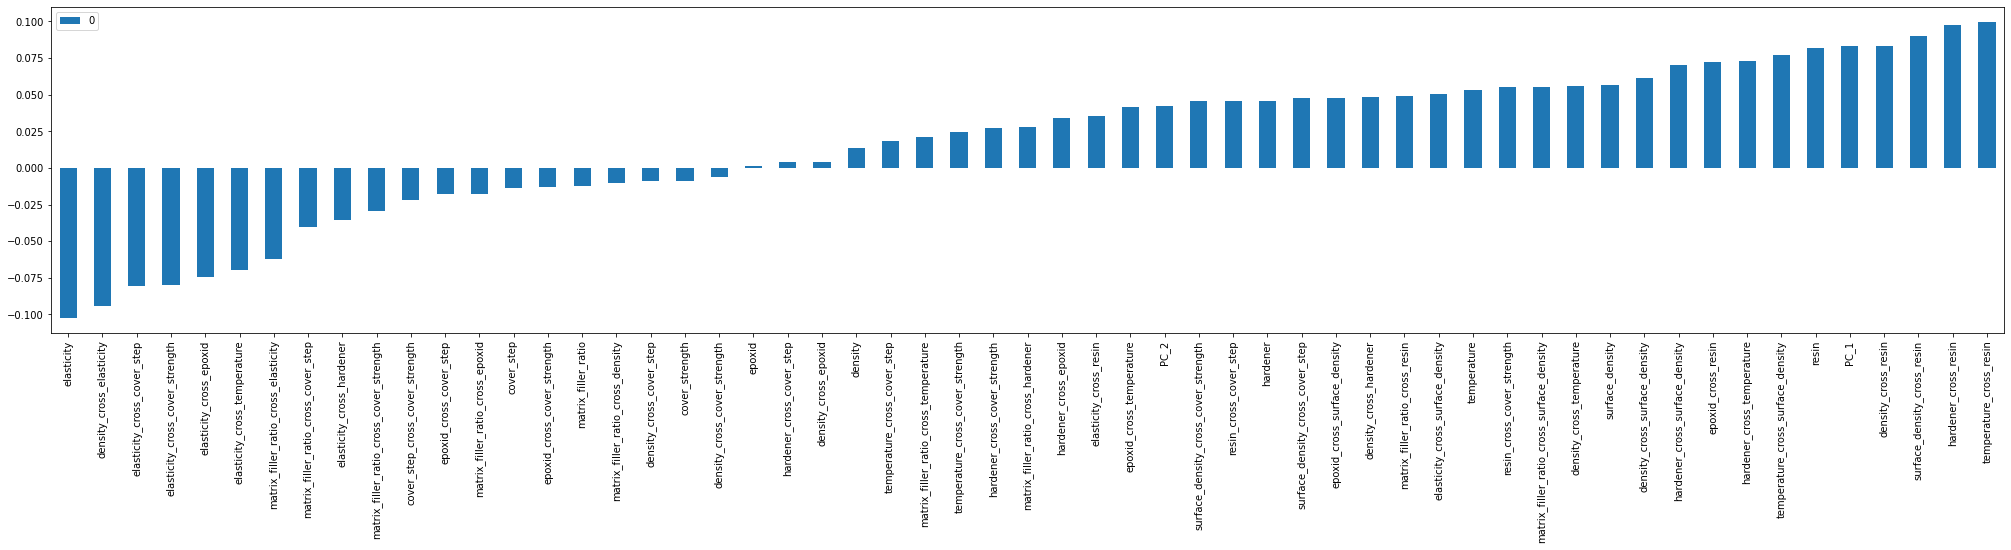

In [36]:
pd.DataFrame(data_test_temp.drop(columns=['cover_angle']).corrwith(data_test_temp['elasticity_on_stretching']).sort_values()[:-1]).plot(kind='bar', figsize=(35, 6));

# Сравнение результатов разных алгоритмов (это пока только первые расчёты, на которых всё и ломается - R2 по test-выборке стабильно лежит "ниже плинтуса")

### Model_1

In [38]:
# Была большая надежда на GaussianProcessRegressor, т.к. почти все исходные признаки показывали нормальную форму распределения.

gpr = GaussianProcessRegressor(n_restarts_optimizer=5, random_state=42).fit(X_train_to_use, y_train.values.ravel())

print(f'R2 train: {gpr.score(X_train_to_use, y_train.values.ravel())}')
print(f'R2 train: {gpr.score(X_test_to_use, y_test.values.ravel())}')

R2 train: 0.9942628079856363
R2 train: -5270.729726281078


### Model_2

In [39]:
# В качестве дальнейшей разведки берём классику - Random Forest, предполагая, что он-то должен грубо (пока без тонкой настройки) обучить модель и 
# показать более-менее адекватный результат по test выборке, но нет - R2 по test отрицательный, и это беда...

model_forest = RandomForestRegressor(n_estimators=1000, max_features='auto', max_depth=5, criterion='squared_error', random_state=42)
model_forest.fit(X_train_to_use, y_train.values.ravel())

y_train_pred = model_forest.predict(X_train_to_use)
y_test_pred = model_forest.predict(X_train_to_use)

R2_train = model_forest.score(X_train_to_use, y_train.values.ravel())
R2_test = model_forest.score(X_test_to_use, y_test.values.ravel())

print(f'R2 train: {R2_train}')
print(f'R2 train: {R2_test}')

R2 train: 0.3007301825443768
R2 train: -0.048166066639998784


### Экспериментировал, как с разным набором признаков (с добавлением кросс-эффектов, возведение в степень, компонетны - с ними и без). так и со стандартизацией/нормализацией/нормированием - результат не меняется... R2 показатель по test выборке, либо ничточно мал, либо отрицательный ((( 